# Reinforcement Learning Tutorial: <br>Semi-gradient n-step Sarsa and Sarsa($\lambda$)<br>Theory and Implementation

Reinforcement Learning (RL) is an exciting area of A.I that offers something entirely different to supervised or unsupervised techniques. In RL, an 'agent' learns to interact with an environment in a way that maximises the reward it receives with respect to some task. RL is distinct from supervised learning, which specifies via labelled examples the correct way for a system to act in every situation (whereas in RL only the end goal is specified, but not how to achieve it). It is also distinct from unsupervised learning, which although not dependent on examples of correct behaviour either, is concerned with finding hidden structure in unlabelled data rather than maximising reward signals.

This tutorial focuses on two important and widely used RL algorithms, semi-gradient n-step Sarsa and Sarsa($\lambda$), as applied to the Mountain Car problem. These algorithms, aside from being useful, pull together a lot of the key concepts in RL and so provide a great way to learn about RL more generally. Value functions, policy iteration, on vs off-policy control, bootstrapping, tabular vs approximate solution methods, state featurization and eligibility traces can all be understood by studying these two algorithms.

[Part 1](#theory) of the tutorial summarises the key theoretical concepts in RL that n-step Sarsa and Sarsa($\lambda$) draw upon. [Part 2](#implementation) implements each algorithm and its associated dependencies. [Part 3](#experiments) compares the performance of each algorithm through a number of simulations. [Part 4](#conclusion) wraps up and provides direction for further study.

The two main resources I drew upon to make this tutorial were [Sutton and Barto's Introduction to Reinforcement Learning](http://www.incompleteideas.net/book/bookdraft2017nov5.pdf) (imges were also taken from here) and [Denny Britz's excellent implementations](https://github.com/dennybritz/reinforcement-learning) of some of the algorithms therein. The implementation for the [Mountain Car environment](https://gym.openai.com/envs/MountainCarContinuous-v0/) was imported from the OpenAI Gym, and the tile coding software used for state featurization was also from Sutton and Barto, installed from [here](http://incompleteideas.net/tiles/tiles3.html).

## 1 &nbsp; Theory <a id='theory'></a>

We first cover the key concepts in RL that n-step Sarsa and Sarsa($\lambda$) draw upon.

### 1.1 &nbsp; Value Functions <a id='value_functions'></a>

Nearly all reinforcement learning algorithms involve estimating value functions, functions of states (or state-actions) that quantify how good it is for an agent to be in a particular state (or state-action pair), where 'good' is defined in terms of the rewards expected to follow from that state (or state-action pair) in the future. The rewards that can be expected depend on which actions will be taken, and so value functions must be defined with respect to particular policies $\pi(a | s)$, which map from states to actions.

Formally, the state-value of $s$ under policy $\pi$ is defined as the expected $\textit{return}$ $G_t = \sum_0^\infty \gamma^k R_{t+k+1}$ when starting from $S_t$ and following $\pi$ thereafter: 

$$v_\pi(s) = \mathbb{E}_\pi[G_t | S_t = s]$$ 

$R_t$ is the reward received at time step $t$ and $\gamma$ is the discount rate, $ 0 \leq \gamma \leq 1$, which controls the relative weighting between near and far-sighted rewards, and ensures that the sum is finite for continuing tasks (i.e. those that don't naturally break down into terminating episodes).

Similarly, the action-value (a.k.a q-value) of (s, a) under policy $\pi$ is defined as the expected return when taking action $a$ in state $s$ and following policy $\pi$ thereafter: 

$$q_\pi(s, a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$$

### 1.2 &nbsp; Policy Evaluation and the Prediction Problem <a id='policy_evaluation'></a>

If we have a model of the environment's transition dynamics  $p(s′,r|s,a)$ , i.e the probabilities of which states and actions lead to which next states and rewards, then the value functions can be computed analytically. However, most of the time the dynamics are not known and the value functions must instead be estimated from actual sample experience, giving rise to $V(S_t) \approx v_\pi(S_t)$ and $Q(S_t, A_t) \approx q_\pi(S_t, A_t)$. The general approach to computing these estimations is to have the agent follow $\pi$ and maintain for each state (or state-action) a running average of the returns that follow. This boils down to iterating over an update rule with the following general form:

$$NewEstimate \gets OldEstimate + \alpha\ [Target - OldEstimate]$$

$Target$ is just the return from the current state (or state-action). This could be the actual return $G_t$, or some estimation of it (as we shall see below). The name $Target$ is appropriate since it indicates the desirable direction in which to move. $\alpha$ then indicates by how much to move in this direction. For an equally weighted average we would choose $\alpha=1/n$, where $n$ is the number of times the given state (or state-action) has been visited so far. However, most reinforcement learning problems are non-stationary, meaning that the true state and state-action values change over time as the policy changes towards an optimal one (see below). In this case it makes more sense to give more weight to recent returns than long-past returns, which can be achieved by holding $\alpha$ constant. The task of making the value estimates consistent with the current policy being followed is called the Prediction Problem.

### 1.3 &nbsp; Policy Improvement

Policy evaluation is concerned with making the state or action-values consistent with the current policy being followed. Policy improvement is concerned with adjusting the current policy to one that when followed leads to a higher return. 

Policy improvement requires an estimate of the action-value function $Q(S_t, A_t) \approx q_\pi(S_t, A_t)$ as opposed to an estimate of the state-value function $V(S_t) \approx v_\pi(S_t)$, assuming the environments transition dynamics are not known. This is because whilst $V(S_t)$ tells you which states have the highest values, it does not tell you which actions lead to which states (we can't look ahead). $Q(S_t, A_t)$, however, directly caches the value of taking a particular action in a particular state, and so it isn't necessary to look ahead to where that action leads in order to determine its value.

Suppose then that we have determined a good approximation $Q$ to the action-value function $q_\pi$ for an arbitrary policy $\pi$ via policy evaluation. We can improve on this policy simply by selecting at each state $s$ the action that appears best according to $Q(s, a)$ i.e. by switching to a new policy $\pi^\prime$ that is 'greedy' with respect to $Q(s, a)$. The new greedy policy $\pi^\prime$ is guaranteed to be better than the original policy $\pi$ for all $s$ and $a$.

### 1.4 &nbsp; Policy iteration and the Control Problem

Once a policy has been improved using $Q(S_t, A_t) \approx  q_\pi(S_t, A_t)$ to yield a better policy $\pi^\prime$, we can then evaluate this new policy to find $Q(S_t, A_t) \approx  q_{\pi^\prime}(S_t, A_t)$, before improving it once again to yield an even better policy $\pi^{\prime \prime}$. By alternating these two processes, policy improvement and policy evaluation, we achieve a sequence of monotonically improving policies and value functions that converge towards the optimal policy and value function, $\pi_*$ and $q_*$. This is called policy iteration. 

In policy iteration, each process completes before the other begins. This is not necessary and can slow down learning. Generalized policy iteration (GPI) refers to the general idea of letting the policy improvement and evaluation processes interact at an arbitrary level of granularity. For example, policy evaluation could be truncated after a single sweep of the state set, or when the task is episodic, after just a single episode, before performing a step of policy improvement. The latter is the approach we take in the implementations of this tutorial. The task of learning optimal policies in general is called the Control Problem.


<center><img src="images/policy_iteration.png" width="180"></center>

### 1.5 &nbsp; On Policy vs Off-Policy Control <a id='on_off_policy'></a>

Policy iteration is only guaranteed to converge if each action is selected infinitely often in the limit. This will not be the case in the approach described above, since by always making the policy greedy with the current action-value function, we prevent exploration of the non-greedy actions. This problem can be mitigated if exploring starts are enforced, where each state has a non-zero probability of being selected to start the episode. However, for most practical situations where episodes are simulated from real experience, this is an unlikely assumption to make.

There are two other approaches to ensuring that all actions continue to be selected: on-policy and off-policy methods. In on-policy methods, 
we continually make the policy $\epsilon$-greedy w.r.t the current value function rather than deterministically greedy. This means that most of the time the maximising action is selected, but with probability $\epsilon$ it selects an action at random. Convergence is guaranteed, since all actions continue to be selected. However, convergence is not actually towards the optimal (greedy) policy, but rather to a nearby one that still explores. 

In off-policy methods we avoid the compromise of learning a policy that is only near-optimal by leveraging two separate policies, one that is continually made greedy w.r.t the current value function and so becomes the optimal policy (a.k.a the target policy), and another that is more exploratory and used to generate sample experience (a.k.a the behaviour policy). Importance sampling is the mechanism that allows us to learn about the target policy using data generated by the behaviour policy; we don't go into detail about this, since the examples in this tutorial use on-policy methods.

### 1.6 &nbsp; Tabular Solution Methods <a id='tabular_methods'></a>

Here we describe the core model-free methods for learning optimal policies and value functions when the state and action spaces are small enough for us to learn distinct values for each and every state (or state-action). In this setting the value functions can be represented as arrays, or tables, which is why these methods are called tabular solution methods. These methods are distinguished only by the target used in the [update rule](#policy_evaluation) above, and so this is what we focus the discussion on.  

#### 1.6.1 &nbsp; Monte Carlo (MC) Methods

The target formed in Monte Carlo methods is simply $G_t$, the complete sample return. The MC update for state-values is therefore:

$$ V(S_t) \gets V(S_t) + \alpha[G_t - V(S_t)]$$

Since each $G_t$ is an unbiased estimator of $v_\pi(s)$, i.e. $\mathbb{E}[G_t | S_t = s] = v_\pi(S_t)$, the average of these returns will converge in the long run to $v_\pi(s)$. However, since the selection of actions in an episode is stochastic, there will be a high variance amongst the returns. Also, because $G_t$ is only available at the end of an episode, we must wait until then before we can make an update (i.e. updates are 'off-line'). Both of these things can result in slow learning.

For action-values we simply switch $V(S_t)$ for $Q(S_t, A_t)$ in the update rule:

$$ Q(S_t, A_t) \gets Q(S_t, A_t) + \alpha[G_t - Q(S_t, A_t)]$$

#### 1.6.2 &nbsp; One-step Temporal Difference (TD) Methods

The target formed in one-step TD methods is the truncated return $G_{t:t+1} = R_{t+1} + V(S_{t+1})$. In other words, $G_{t:t+1}$ is a re-estimation of the value of the current state made at the $\textit{next}$ timestep $t+1$ (hence the name 'temporal difference'). The one-step TD update for state-values is thus:

$$ V(S_t) \gets V(S_t) + \alpha[G_{t:t+1} - V(S_t)]$$

Whilst the MC target was an unbiased estimate of $v_\pi(S_t)$, this time it is biased, due to its dependence on the estimate $V(S_{t+1})$. Basing an estimate off of other estimates like this is called 'bootstrapping'. The payoff we get for introducing bias is lower variance, since the target only depends on one stochastic action selection. Also, whilst the MC target was only available at the end of the episode, this time it is available at $t+1$, since it only depends on the next state and reward. TD updates can therefore be performed 'on-line' (during an episode) which can result in faster learning (our value estimates are better sooner, enabling our agent to more immediately exploit anything that has changed).

The fact that TD converges implies that the estimates of $v_\pi(s)$ made at future time steps are better than those made at the current time step. This makes intuitive sense: if I asked you to estimate the length of your commute home as you got in the car, your re-estimate of that value once you've seen how much traffic there is on the motorway is likely to be more accurate.

Once again for action-values we simply switch the $V$s for $Q$s in the update rule:

$$ Q(S_t, A_t) \gets Q(S_t, A_t) + \alpha[G_{t:t+1} - Q(S_t, A_t)] $$

with $G_{t:t+1} = R_{t+1} + Q(S_{t+1}, A_{t+1})$. This action-value update depends on every element of the quintuple of events $(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1})$, and so is referred to by the name one-step $\textit{Sarsa}$. 

#### 1.6.3 &nbsp; n-step TD Methods

n-step TD methods generalize one-step TD presented above. Whilst one-step TD methods use the target $G_{t:t+1} = R_{t+1} + V(S_{t+1})$, n-step TD methods use the target $G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \ldots + \gamma^{n-1} R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n})$. In other words, one-step TD updates bootstrap from $V(S_{t+1})$, whilst n-step updates bootstrap from $V(S_{t+n})$. The n-step TD update for state-values is therefore:

$$ V(S_t) \gets V(S_t) + \alpha[G_{t:t+n} - V(S_t)]$$

As usual we arrive at the corresponding update for action-values by swapping the $V$s for $Q$s:

$$ Q(S_t, A_t) \gets Q(S_t, A_t) + \alpha[G_{t:t+n} - Q(S_t, A_t)],$$

with $G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \ldots + \gamma^{n-1} R_{t+n} + \gamma^n Q_{t+n-1}(S_{t+n}, A_{t+n})$. This action-value form is called n-step Sarsa, by analogy with one-step Sarsa above. 

n-step TD methods span a spectrum with one-step TD at one end (n=1) and MC at the other (n equal to the number of steps in the episode). Increasing n reduces the bias of the estimator (moving us closer towards the unbiased estimates of MC) but increases the variance, as well as the time we have to wait before we can make an update. Often intermediate values of n are are the most effective.

### 1.7 &nbsp; Approximate Solution Methods

If there are very many states then it becomes impractical, both in terms of memory and time, to find accurate estimates of all states (or state-actions) like tabular methods. Instead we maintain our value function estimates as parameterized functions, $\hat{v}(s, \mathbf{w})$ and $\hat{q}(s, a, \mathbf{w})$, where $\mathbf{w} \in \mathbb{R}^d$ is the weight vector, whose dimensionality $d$ is much less than the number of states. $\mathbf{w}$ is learned via an update rule, in the same way that individual states and state-actions are in tabular methods. Because an update to the weight vector affects the values of many different states (and state-actions), approximate solution methods have the ability to generalise to previously unseen states (and state-actions).

#### 1.7.1 &nbsp; Update Rule for Approximate Solution Methods <a id='approximate_update'></a>

We borrow from supervised learning methodology in order to formulate the update rule for $\mathbf{w}$, and thus learn the parameterised value functions $\hat{v}(s, \mathbf{w})$ and $\hat{q}(s, a, \mathbf{w})$. If we denote the update rule for state-values as $S_t \to U_t$, where $S_t$ is the state whose value is to be updated and $U_t$ is a target that doesn't depend on $\mathbf{w}$, then we can interpret $(S_t, U_t)$ as an input-output training example for $\hat{v}$. If we use the mean squared error to represent prediction error for this example, $[U_t - \hat{v}(S_t, \mathbf{w})]^2$, then we can perform the weight vector update via stochastic gradient descent (SGD):

$$\begin{aligned} 
\mathbf{w}_{t+1} &= \mathbf{w}_t - \frac{1}{2} \alpha \nabla \left[U_t - \hat{v}(S_t, \mathbf{w}_t) \right]^2 \\
&= \mathbf{w}_t + \alpha \left[U_t - \hat{v}(S_t, \mathbf{w}_t) \right] \nabla \hat{v}(S_t, \mathbf{w}_t)
\end{aligned}$$

We arrive at the corresponding update step for action-values by substituting the $\hat{v}$s for $\hat{q}$s. 

#### 1.7.2 &nbsp; Gradient and Semi-gradient methods

Each of the [tabular solution methods](#tabular_methods) has an approximate solution version that use the [gradient update rule](#approximate_update) above. Once again, these methods are distinguished by the target $U_t$ used. 

For example, the target for the approximate MC method is simply $U_t=G_t$, giving rise to 'Gradient MC' methods. The target for the approximate n-step TD method is $U_t=G_{t:t+n}$ (and similarly for n-step Sarsa). However, this bootstrapping target depends on the current value of $\mathbf{w}$, which breaks the key assumption of the gradient update rule above. Methods that use this update are therefore called 'Semi-gradient' methods, since they ignore part of the gradient. Convergence is nonetheless assured in certain cases, for example when a linear value function approximator is used ([see below](#linear_approximation)).

#### 1.7.3 &nbsp; Semi-gradient TD($\lambda$)

Gradient MC and Semi-gradient n-step TD directly parallel their tabular counterparts. However, function approximation techniques also allow us to introduce something new, TD($\lambda$). This method is a bit more subtle than those we have already met, and so requires a bit more explanation.

MC and n-step TD methods takes a forward-view: values of states are updated by looking ahead to the values of future states. This works well, but means that the target is not actually available until $n$ steps into the future. This means that the updates are not equally distributed in time: our first update is delayed by $n$ steps from the start of an episode, and this leaves us $n$ updates to catch up after the episode has finished. Additionally, in order to perform each update we must maintain a store of the last $n$ feature vectors (and rewards), which comes with computational cost.

TD($\lambda$) converts these forward view methods into backward-view versions. The mechanism for this is a short-term memory vector, the eligibility trace $\mathbf{z}_t \in \mathbb{R}^d$, that parallels the long-term weight vector $\mathbf{w} \in \mathbb{R}^d$, keeping track of  which components of $\mathbf{w}$ have contributed to recent state valuations. 

$$\begin{align} &\mathbf{z}_{-1} = \mathbf{0} \\
 &\mathbf{z}_t = \gamma \lambda \mathbf{z}_{t-1} + \nabla \hat{v}(S_t, \mathbf{w}_t), \quad 0 \leq t \leq T,\end{align}$$
 
where $\gamma$ is the usual discount rate, $\lambda \in [0, 1]$, and the product of these two quantities defines the concept of 'recent' in the description above.

The trace indicates which components of $\mathbf{w}$ deserve most credit for the error at the current state, where error is defined by the moment-by-moment one-step TD error, $\delta_t = G_{t:t+1} - \hat{v}(S_t, \mathbf{w}_t)$. Components of $\mathbf{w}$ that have contributed most recently, or most frequently to preceding state valuations are assigned the most credit, and are said to be the most 'eligible' for an update. Concretely, each component of $\mathbf{w}$ is updated in proportion to the scalar TD error and it's corresponding component in the vector eligibility trace.

$$\mathbf{w}_{t+1} = \mathbf{w}_t + \alpha \delta_t \mathbf{z}_t. $$

In forward view n-step TD we can imagine the agent moving through state space with a telescope, looking ahead to future rewards and states in order to evaluate the currently visited state. In the backward view TD($\lambda$), we can imagine the same agent moving through state space with a blindfold, computing the TD error at each state visited, and shouting this back to previously visited states. 

When $\lambda = 0$ the trace is exactly the state-value gradient for $S_t$, and the update for $\mathbf{w}$ reduces to the one-step semi-gradient TD update. When $\lambda = 1$ the trace decays only according to $\gamma$ and, although this is not as trivial to see, the update reduces to the MC Gradient update. Intermediate values of $\lambda$ represent intermediate levels of bootstrapping between these two extremes, just as intermediate values of $n$ represent intermediate levels of bootstrapping in the n-step TD algorithm.

In fact it can be shown that the TD($\lambda$) is exactly equivalent to n-step TD, but with the n-step return $G_{t:t+n}$ replaced by a compound return composed of a weighted average of $\textit{all}$ the n-step returns, each weighted proportional to
$\lambda^{n-1}$ (the same $\lambda$ as above) and normalised by a factor of $1-\lambda$ to ensure that the weights sum to $1$. This is called the $\lambda$-return, $G_t^\lambda$.

$$ G_t^\lambda = (1 - \lambda) \sum_{n=1}^\infty \lambda^{n-1}G_{t:t+n}. $$

This equivalence can be seen easily for the cases $\lambda = 0$ and $\lambda = 1$. In the former case $G_t^\lambda$ reduces to $G_{t:t+1}$, the one-step TD return, and in the latter it reduces to $G_t$, the complete MC return, which is consistent with the behaviour of TD($\lambda$) above.

The advantages of eligibilty traces over n-step methods are clear. Updates are now performed continually and uniformly in time rather than being delayed $n$ steps and then catching up at the end of the episode (note that for the $\lambda$-return we would actually have to wait all the way until the end of the episode to make the first update since only then is the longest of its component returns available). This means that learning can occur and affect behaviour immediately after a state is encountered rather than being delayed $n$ steps. Additionally, now only a single trace vector needs storing rather than the last n feature vectors.

The formulation we have used for the eligibility trace is called the accumulating trace: each time a state is visited the corresponding components of $\mathbf{z}$ are bumped up, decaying away between visits. Another kind of trace is called the replacing trace, which resets the components back to $1$ on each state visit rather than growing them any further (i.e. the frequency with which components of $\mathbf{w}$ have contributed to recent state valuations is dropped as a measure of eligibility).

Of course the concept of eligibility traces works for action-value function approximation methods too. As usual all that is required is to swap $\hat{v}$s for $\hat{q}$s in the discussion above. The resulting methods are called Sarsa($\lambda$) methods.

#### 1.7.4 &nbsp; Linear Value Function Approximation <a id='linear_approximation'></a>

An important special case of value function approximation (which can be applied to all the gradient and semi-gradient methods we have encountered so far) is that for which $\hat{v}(s, \mathbf{w})$ is a linear function of $\mathbf{w}$:

$$ \hat{v}(s, \mathbf{w}) = \mathbf{w}^\top \mathbf{x}(s) = \sum_i^d w_i x_i(s). $$

$\mathbf{x}(s)$ here is a featurized representation of $s$, of the same dimensions as $\mathbf{w}$ ([see below](#feature_construction)). The gradient of the approximate value function with respect to $\mathbf{w}$ in this linear case is simply $\nabla \hat{v}(s, \mathbf{w}) = \mathbf{x}(s)$, which reduces the SGD weight vector update to:

$$ \mathbf{w}_{t+1} = \mathbf{w}_t + \alpha \left[U_t - \hat{v}(S_t, \mathbf{w}_t) \right] \mathbf{x}(S_t). $$

For action-values, the $\hat{v}$s are replaced with $\hat{q}$s, and $\mathbf{x}(s)$ becomes $\mathbf{x}(s, a)$, the featurized representation of the state-action pair $(s, a)$. 

#### 1.7.5 &nbsp; Feature Construction for Linear Methods <a id='feature_construction'></a>

Suppose our states $s$ have two numerical dimensions, or features, $s_1$ and $s_2$. For example, $s_1$ could be position and $s_2$ velocity, as is the case with the Mountain Car task that we consider in part 2 of this tutorial. The most natural 'featurization' for $s$ would be $\mathbf{x} = (s_1, s_2)^\top$.

A limitation of the linear value function approximator is that it can't take into account interactions between features, such as a high value for $s_1$ only being good in the presence of a positive value for $s_2$ in the example above. The only way to model such interdependencies would be to include in the featurization of $s$ features that combine $s_1$ and $s_2$. For example, we could use a polynomial featurization such as $\mathbf{x}(s) = (1, s_1, s_2, s_1s_2, s_1s_2^2, s_1^2s_2, s_1^2s_2^2)^\top$.

Tile coding is another way to construct features that is more flexible and scalable than polynomial featurization. In tile coding, the state space is covered by multiple tilings, with each tiling composed of multiple tiles. The tilings are offset from one another by a fraction of the tile width. The state featurization $\mathbf{x}(s)$ has one feature for each tile in each tiling, so if there are $n$ tilings and $k \times k$ tiles in each tiling, $\mathbf{x}(s) \in \mathbb{R}^{n \times k \times k}$. A particular feature is $1$ (active) if the state falls within the corresponding tile and $0$ (inactive) otherwise. Since every position in state space falls in exactly one tile in each of the $n$ tilings, there are always $n$ active features in $\mathbf{x}(s)$. 


<center><img src="images/tile_coding.png" width="600"></center>

A nice side-effect of the above is that the learning rate $\alpha$ in the [gradient update rule](#linear_approximation) can be set in an intuitive way. In particular, if $\alpha=\frac{1}{n}$, then the new estimate $\hat{v}(s, \mathbf{w}_{t+1}) = U_t$, regardless of the prior estimate $\hat{v}(s, \mathbf{w}_{t+1})$ (this follows from both the form of the gradient update rule as well as the form of $\hat{v}(s, \mathbf{w})$). Usually we only want to move some fraction ${x}$ of the way to the target $U_t$, which can be achieved by setting $\alpha=\frac{x}{n}$ instead. 

Tile coding ensures generalization because if we train at one state $s$, a single point in state space, then the weights associated with all ($n$) tiles covering $s$ will be updated. In turn, the approximate value function for all states within the union of these active tiles will change, proportional to the number of tiles they have in common. The shape and offset of the tiles will affect the type of generalization. For example, if the tiles are elongated along a particular dimension in state space, then generalization will extend further to states along this dimension. The number and size of the tiles will determine the finest level of discrimination possible between states - how far you have to move in state space in order to change at least one component of the featurization. 

Because tile coding uses binary features, the approximate value function $\hat{v}(s, \mathbf{w})$ in the linear case is almost trivial to compute:

$$ \hat{v}(s, \mathbf{w}) = \mathbf{w}^\top \mathbf{x}(s) = \sum_i^d w_i x_i(s) \equiv \sum_{i \in \{x_i = 1\}}w_i$$ 

In order to compute the approximate action-value function $\hat{q}(s, a, \mathbf{w})$, we simply need to replace $\mathbf{x}(s)$ by $\mathbf{x}(s, a)$. The latter can be computed by making the tilings cover the whole state-action space as opposed to just the state-space.

## &nbsp; 2 Implementation <a id='implementation'></a>

We now implement n-step Sarsa and Sarsa($\lambda$) and their associated dependencies. These implementations should be well understood by studying [Part 1](#theory) above; comments have been added to steps that may require extra explanation.

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import time
import timeit
from collections import namedtuple

from lib.tile_coding import IHT, tiles
from matplotlib import pyplot as plt
from matplotlib import cm
matplotlib.style.use('ggplot')

In [2]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 3000  # Increase upper time limit so we can plot full behaviour.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
class QEstimator():
    """
    Linear action-value (q-value) function approximator for 
    semi-gradient methods with state-action featurization via tile coding. 
    """
    
    def __init__(self, step_size, num_tilings=8, max_size=4096, tiling_dim=None, trace=False):
        
        self.trace = trace
        self.max_size = max_size
        self.num_tilings = num_tilings
        self.tiling_dim = tiling_dim or num_tilings

        # Step size is interpreted as the fraction of the way we want 
        # to move towards the target. To compute the learning rate alpha,
        # scale by number of tilings. 
        self.alpha = step_size / num_tilings

        # Initialize index hash table (IHT) for tile coding.
        # This assigns a unique index to each tile up to max_size tiles.
        # Ensure max_size >= total number of tiles (num_tilings x tiling_dim x tiling_dim)
        # to ensure no duplicates.
        self.iht = IHT(max_size)

        # Initialize weights (and optional trace)
        self.weights = np.zeros(max_size)
        if self.trace:
            self.z = np.zeros(max_size)

        # Tilecoding software partitions at integer boundaries, so must rescale
        # position and velocity space to span tiling_dim x tiling_dim region.
        self.position_scale = self.tiling_dim / (env.observation_space.high[0] \
                                                  - env.observation_space.low[0])
        self.velocity_scale = self.tiling_dim / (env.observation_space.high[1] \
                                                  - env.observation_space.low[1])
        
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a 
        state-action pair.
        """
        featurized = tiles(self.iht, self.num_tilings, 
                           [self.position_scale * state[0], 
                            self.velocity_scale * state[1]], 
                           [action])
        return featurized
    
    def predict(self, s, a=None):
        """
        Predicts q-value(s) using linear FA.
        If action a is given then returns prediction
        for single state-action pair (s, a).
        Otherwise returns predictions for all actions 
        in environment paired with s.   
        """
    
        if a is None:
            features = [self.featurize_state_action(s, i) for 
                        i in range(env.action_space.n)]
        else:
            features = [self.featurize_state_action(s, a)]
            
        return [np.sum(self.weights[f]) for f in features]
        
            
    def update(self, s, a, target):
        """
        Updates the estimator parameters
        for a given state and action towards
        the target using the gradient update rule 
        (and the eligibility trace if one has been set).
        """
        features = self.featurize_state_action(s, a)
        estimation = np.sum(self.weights[features])  # Linear FA
        delta = (target - estimation)
        
        if self.trace:
            # self.z[features] += 1  # Accumulating trace
            self.z[features] = 1  # Replacing trace
            self.weights += self.alpha * delta * self.z
        else:
            self.weights[features] += self.alpha * delta
                
    
    def reset(self, z_only=False):
        """
        Resets the eligibility trace (must be done at 
        the start of every epoch) and optionally the
        weight vector (if we want to restart training
        from scratch).
        """
        
        if z_only:
            assert self.trace, 'q-value estimator has no z to reset.'
            self.z = np.zeros(self.max_size)
        else:
            if self.trace:
                self.z = np.zeros(self.max_size)
            self.weights = np.zeros(self.max_size)
        

In [4]:
def make_epsilon_greedy_policy(estimator, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on a 
    given q-value approximator and epsilon.    
    """
    def policy_fn(observation):
        action_probs = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = estimator.predict(observation)
        best_action_idx = np.argmax(q_values)
        action_probs[best_action_idx] += (1.0 - epsilon)
        return action_probs
    return policy_fn

In [5]:
def sarsa_n(n, env, estimator, gamma=1.0, epsilon=0):
    """
    n-step semi-gradient Sarsa algorithm
    for finding optimal q and pi via Linear
    FA with n-step TD updates.
    """
    
    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    # Set up trackers
    states = [state]
    actions = [action]
    rewards = [0.0]

    # Step through episode
    T = float('inf')
    for t in itertools.count():
        if t < T:           
            # Take a step
            next_state, reward, done, _ = env.step(action)
            states.append(next_state)
            rewards.append(reward)

            if done:
                T = t + 1

            else:
                # Take next step
                next_action_probs = policy(next_state)
                next_action = np.random.choice(
                    np.arange(len(next_action_probs)), p=next_action_probs)

                actions.append(next_action)

        update_time = t + 1 - n  # Specifies state to be updated
        if update_time >= 0:       
            # Build target
            target = 0
            for i in range(update_time + 1, min(T, update_time + n) + 1):
                target += np.power(gamma, i - update_time - 1) * rewards[i]
            if update_time + n < T:
                q_values_next = estimator.predict(states[update_time + n])
                target += q_values_next[actions[update_time + n]]
            
            # Update step
            estimator.update(states[update_time], actions[update_time], target)
        
        if update_time == T - 1:
            break

        state = next_state
        action = next_action
    
    ret = np.sum(rewards)
    
    return t, ret

In [6]:
def sarsa_lambda(lmbda, env, estimator, gamma=1.0, epsilon=0):
    
    """
    Sarsa(Lambda) algorithm
    for finding optimal q and pi via Linear
    FA with eligibility traces.
    """
    
    # Reset the eligibility trace
    estimator.reset(z_only=True)

    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    ret = 0
    # Step through episode
    for t in itertools.count():
        # Take a step
        next_state, reward, done, _ = env.step(action)
        ret += reward

        if done:
            target = reward
            estimator.update(state, action, target)
            break

        else:
            # Take next step
            next_action_probs = policy(next_state)
            next_action = np.random.choice(
                np.arange(len(next_action_probs)), p=next_action_probs)

            # Estimate q-value at next state-action
            q_new = estimator.predict(
                next_state, next_action)[0]
            target = reward + gamma * q_new
            # Update step
            estimator.update(state, action, target)
            estimator.z *= gamma * lmbda

        state = next_state
        action = next_action    
    
    return t, ret
    

## 3 &nbsp; Experiments <a id='experiments'></a>

We now compare the performance of n-step Sarsa and Sarsa($\lambda$) applied to the [Mountain Car problem](https://gym.openai.com/envs/MountainCarContinuous-v0/). This is a classic episodic task commonly used to benchmark RL algorithms, where the goal is to get a car to the top of a hill, the catch being that the engine is not strong enough on its own so the agent must learn to exploit gravity. 

The simulations we run use the implementations from [Part 2](#implementation). Note that for both algorithms we use the default of $\epsilon=0$. This is OK because the Mountain Car environment yields a reward of $-1$ for each action unless it leads directly to the top of the hill (when it a yields reward of $0$). Our zero initialisation of the q-value function is therefore optimistic, and so the agent still explores (at least at the start of training). We also use the default of $\gamma=1$ as discounting isn't strictly necessary in episodic tasks.

### 3.1 &nbsp; Plotting Utility Functions

In [7]:
def plot_cost_to_go(env, estimator, num_partitions=50):
    """
    Plots -Q(s, a_max) for each state s=(position, velocity) 
    in the environment where a_max is the maximising action 
    from s according to our q-value estimator Q.
    The state-space is continuous hence we first discretise 
    it into num_partitions partitions in each dimension. 
    """
    
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_partitions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_partitions)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(
        lambda obs: -np.max(estimator.predict(obs)), 2, np.stack([X, Y], axis=2))

    fig, ax = plt.subplots(figsize=(10, 5))
    p = ax.pcolor(X, Y, Z, cmap=cm.RdBu, vmin=0, vmax=200)

    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_title("\"Cost To Go\" Function")
    fig.colorbar(p)
    plt.show()

In [15]:
def display_greedy_policy(env, estimator):
    """
    Follows (deterministic) greedy policy
    with respect to the given q-value estimator,
    and animates the result using openAI gym.
    """
    
    env = gym.wrappers.Monitor(env, '/src/', video_callable=lambda episode_id: True)
    # Set epsilon to zero to follow greedy policy
    policy = make_epsilon_greedy_policy(
        estimator=estimator, epsilon=0, num_actions=env.action_space.n)
    # Reset the environment
    state = env.reset()
    for t in itertools.count():
        time.sleep(0.01)  # Slow down animation
        action_probs = policy(state)  # Compute action-values
        [action] = np.nonzero(action_probs)[0]  # Greedy action
        state, _, done, _ = env.step(action)  # Take step
        env.render()  # Animate
        if done:
            print('Solved in {} steps'.format(t))
            break

In [16]:
def plot_learning_curves(stats, smoothing_window=10):
    """
    Plots the number of steps taken by the agent
    to solve the task as a function of episode number,
    smoothed over the last smoothing_window episodes. 
    """
    
    plt.figure(figsize=(10,5))
    for algo_stats in stats:
        steps_per_episode = pd.Series(algo_stats.steps).rolling(
            smoothing_window).mean()  # smooth
        plt.plot(steps_per_episode, label=algo_stats.algorithm)
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.title("Steps per Episode")
    plt.legend()
    plt.show()

In [10]:
def plot_grid_search(stats, truncate_steps=400):
    """ 
    Plots average number of steps taken by the agent 
    to solve the task for each combination of
    step size and boostrapping parameter
    (n or lambda).
    """
    # Truncate high step values for clearer plotting
    stats.steps[stats.steps > truncate_steps] = truncate_steps
    
    # We use -1 step values indicate corresponding combination of
    # parameters doesn't converge. Set these to truncate_steps for plotting.
    stats.steps[stats.steps == -1] = truncate_steps
    
    plt.figure()
    for b_idx in range(len(stats.bootstrappings)):
        plt.plot(stats.step_sizes, stats.steps[b_idx, :], 
            label='Bootstrapping: {}'.format(stats.bootstrappings[b_idx]))
    plt.xlabel('Step size (alpha * number of tilings)')
    plt.ylabel('Average steps per episode')
    plt.title('Grid Search {}'.format(stats.algorithm))
    plt.ylim(140, truncate_steps - 100)
    plt.legend()

### 3.2 &nbsp; Running n-step Sarsa and Sarsa($\lambda$)

In [11]:
RunStats = namedtuple('RunStats', ['algorithm', 'steps', 'returns'])

In [12]:
def run(algorithm, num_episodes=500, **algorithm_kwargs):
    """
    Runs algorithm over multilple episodes and logs
    for each episode the complete return (G_t) and the
    number of steps taken.
    """
    
    stats = RunStats(
        algorithm=algorithm, 
        steps=np.zeros(num_episodes), 
        returns=np.zeros(num_episodes))
    
    algorithm_fn = globals()[algorithm]
    
    for i in range(num_episodes):
        episode_steps, episode_return = algorithm_fn(**algorithm_kwargs)
        stats.steps[i] = episode_steps
        stats.returns[i] = episode_return
        sys.stdout.flush()
        print("\rEpisode {}/{} Return {}".format(
            i + 1, num_episodes, episode_return), end="")
    return stats

$\textbf{Run n-step Sarsa}$

Episode 500/500 Return -105.0

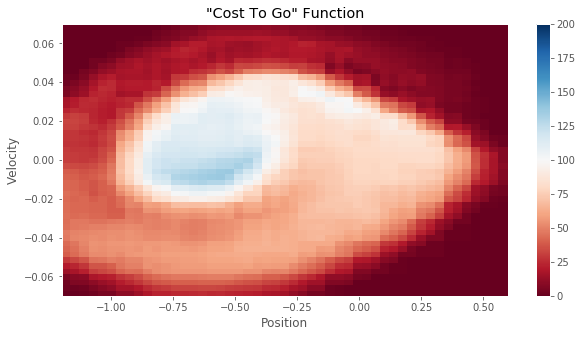

500 episodes completed in 27.76s


In [13]:
step_size = 0.5  # Fraction of the way we want to move towards target
n = 4  # Level of bootstrapping (set to intermediate value)
num_episodes = 500

estimator_n = QEstimator(step_size=step_size)

start_time = timeit.default_timer()
run_stats_n = run('sarsa_n', num_episodes, n=n, env=env, estimator=estimator_n)
elapsed_time = timeit.default_timer() - start_time

plot_cost_to_go(env, estimator_n)
#display_greedy_policy(env, estimator_n)
print('{} episodes completed in {:.2f}s'.format(num_episodes, elapsed_time))

In [17]:
display_greedy_policy(env, estimator_n)

NoSuchDisplayException: Cannot connect to "None"

$\textbf{Run Sarsa}(\lambda)$

In [ ]:
step_size = 0.5 # Fraction of the way we want to move towards target
lmbda = 0.92  # Level of bootstrapping (set to intermediate value)
num_episodes = 500

estimator_lambda = QEstimator(step_size=step_size, trace=True)

start_time = timeit.default_timer()
run_stats_lambda = run('sarsa_lambda', num_episodes, lmbda=lmbda, env=env, estimator=estimator_lambda)
elapsed_time = timeit.default_timer() - start_time

plot_cost_to_go(env, estimator_lambda)
display_greedy_policy(env, estimator_lambda)
print('{} episodes completed in {:.2f}s'.format(num_episodes, elapsed_time))

$\textbf{Compare Learning Curves}$

In [ ]:
plot_learning_curves([run_stats_n, run_stats_lambda])

### 3.3 &nbsp; Grid Search Comparison of n-step Sarsa and Sarsa($\lambda$)

In [28]:
GridSearchStats = namedtuple('GridSearchStats', ['algorithm', 'steps', 'step_sizes', 'bootstrappings'])

In [29]:
def run_grid_search(algorithm, step_sizes, bootstrappings, episodes=100, num_runs=5,
                   **algorithm_kwargs):
    """
    Runs a grid search over different values of the step size
    and boostrapping parameter (n or lambda) for the given algorithm.
    The performance of each combination of parameters is measured 
    by the number of steps taken to complete the task, averaged
    over the first few episodes and a number of
    independent runs.
    """
    
    stats = GridSearchStats(
        algorithm=algorithm, 
        steps=np.zeros((len(bootstrappings), len(step_sizes))),
        step_sizes=step_sizes,
        bootstrappings=bootstrappings)
        
    algorithm_fn = globals()[algorithm]
    trace = True if algorithm == 'sarsa_lambda' else False

    for run_idx in range(num_runs):
        for b_idx, bootstrapping in enumerate(bootstrappings):
            for s_idx, step_size in enumerate(step_sizes):
                if algorithm == 'sarsa_n':
                    if (bootstrapping == 8 and step_size > 1) or \
                    (bootstrapping == 16 and step_size > 0.75):
                        # sarsa_n doesn't converge in these cases so 
                        # assign a default value and skip over.
                        stats.steps[b_idx, s_idx] = -1 * num_runs * episodes
                    continue
                for episode in range(episodes):
                    sys.stdout.flush()
                    print('\r run: {}, step_size: {}, bootstrapping: {}, episode: {}'.format(
                            run_idx, step_size, bootstrapping, episode), end="")
                    episode_steps, _ = algorithm_fn(
                        bootstrapping, estimator=estimator, **algorithm_kwargs)
                    stats.steps[b_idx, s_idx] += episode_steps
                    
    
    # Average over independent runs and episodes
    stats.steps[:] /= (num_runs * episodes)
   
    return stats

$\textbf{Grid Search for n-step Sarsa}$

In [30]:
step_sizes = np.arange(0.1, 1.8, 0.1)
ns = np.power(2, np.arange(0, 5))
grid_search_stats_n = run_grid_search('sarsa_n', step_sizes, ns, env=env)
plot_grid_search(grid_search_stats_n)

 run: 0, step_size: 1.7000000000000002, bootstrapping: 16, episode: 69

RuntimeWarning: overflow encountered in reduce

$\textbf{Grid Search for Sarsa}(\lambda)$

In [ ]:
step_sizes = np.arange(0.1, 1.8, 0.1)
lambdas = np.array([0, 0.68, 0.84, 0.92, 0.98, 0.99])
grid_search_stats_lambda = run_grid_search('sarsa_lambda', step_sizes, lambdas, env=env)
plot_grid_search(grid_search_stats_lambda)

## 4 &nbsp; Conclusion <a id='conclusion'></a>

This tutorial has covered the theory and implementation of two important algorithms in RL, n-step Sarsa and Sarsa($\lambda$). Judging by our experiments in [Part 2](#experiments), Sarsa($\lambda$) appears to learn more efficiently than n-step Sarsa as applied to the Mountain Car task. The agent's ability to immediately learn from and respond to feedback from the environment rather than being delayed n-steps seems to pay off. 

By studying these two algorithms, we have covered most of the key areas of RL. However, there are two important areas that we didn't cover and that is off-policy methods (although we explained at a high level what this was in [section 1.5](#on_off_policy)) and policy gradient methods. Both n-step Sarsa and Sarsa($\lambda$) have off-policy equivalents (so called Q-learning methods) that simulate sample experience from a behaviour policy different from the target policy we are actually learning about, but are otherwise the same as their on-policy counterparts. Policy gradient methods, on the other hand, introduce something entirely new. In these methods, optimal policies are not learned via value functions, but by first parameterising the policy and then optimising it directly via stochastic gradient descent, without consulting a value function at all. Off-policy methods and policy gradient methods are also well worth studying, as many state-of-the-art applications of RL employ such techniques.

Of course we also haven't covered Deep Learning RL methods (such as Deep Q-Learning). However, these are essentially just methods that replace the linear function approximator that we have used with a neural network (we can also do away with tile coding since neural networks are non-linear function approximators already).